## 1. Create a Image Hash.

### Idea from https://github.com/mendesk/image-ndd-lsh

In [1]:
!python3 -m pip install imagehash Image

In [2]:
import imagehash
from PIL import Image
import numpy as np

Article -> https://pypi.org/project/ImageHash/
dhash -> difference hash

In [3]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [139]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

## 2. Create LSH algorithm

### 2.1 Get the dataset

In [140]:
#!apt-get install wget
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [141]:
#!tar -xvzf cifar-10-python.tar.gz

In [142]:
#!rm -rf cifar-10-python.tar.gz
#!mv cifar-10-batches-py ../data

### 2.2 Read the files

In [143]:
import os
import _pickle as cPickle

In [144]:
PATH = "../data/cifar-10-batches-py/"

#### 2.2.1 Load Cifar-10

In [145]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [146]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [147]:
images, labels = load_batch()

In [148]:
labels.shape

(10000,)

In [149]:
image = np.reshape(images[0], (3, 32, 32))

In [150]:
image.shape

(3, 32, 32)

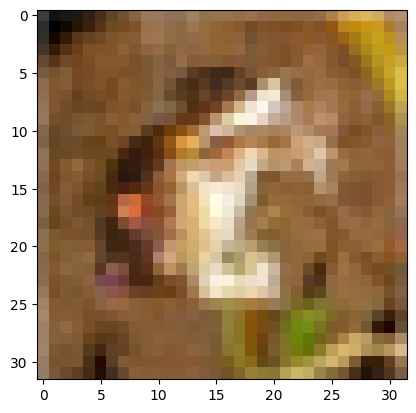

In [151]:
from matplotlib import pyplot as plt
plt.imshow(image.T, interpolation='nearest')
plt.show()

In [152]:
print(label_names[labels[0]])

frog


### 2.2.2 Algorithm

In [153]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            # Keep track of each image's signature
            #print(signature.shape)
            self.signatures[idx] = np.packbits(signature)
            self.fill_buckets(signature, idx)
            idx+=1

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [154]:
images = images.reshape(10000,3,32,32)
images.shape

(10000, 3, 32, 32)

In [155]:
import time

start = time.time()

lsh = LSH(8, 8)
lsh.compute_hash(images)
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.9)

end = time.time()

In [156]:
print( "time: ", end - start )

time:  33.73026442527771


In [157]:
len(duplicates)

127

In [158]:
duplicates

[(8975, 9432, 1.0),
 (4875, 9275, 1.0),
 (3102, 7612, 0.96875),
 (3922, 8559, 0.96875),
 (4320, 9344, 0.96875),
 (6974, 7464, 0.96875),
 (2065, 4828, 0.953125),
 (4828, 8007, 0.953125),
 (5866, 6703, 0.953125),
 (1081, 9811, 0.953125),
 (2145, 9064, 0.953125),
 (4277, 9644, 0.953125),
 (7464, 8387, 0.953125),
 (4828, 7995, 0.953125),
 (4146, 5507, 0.953125),
 (2192, 6717, 0.953125),
 (976, 9206, 0.9375),
 (1851, 9049, 0.9375),
 (84, 8357, 0.9375),
 (661, 2210, 0.9375),
 (5148, 6581, 0.9375),
 (5834, 7774, 0.9375),
 (2219, 4003, 0.9375),
 (2680, 9664, 0.9375),
 (3263, 9664, 0.9375),
 (2603, 6598, 0.9375),
 (1711, 9664, 0.9375),
 (4477, 4655, 0.921875),
 (1323, 1770, 0.921875),
 (2320, 3020, 0.921875),
 (5866, 5904, 0.921875),
 (6974, 8387, 0.921875),
 (8443, 9522, 0.921875),
 (7464, 8661, 0.921875),
 (1323, 7900, 0.921875),
 (6974, 8526, 0.921875),
 (206, 2844, 0.921875),
 (6598, 9644, 0.921875),
 (1853, 3859, 0.921875),
 (2181, 7485, 0.921875),
 (4320, 6898, 0.921875),
 (4828, 8005, 0.

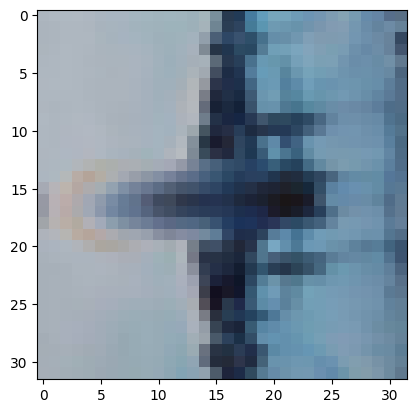

In [136]:
plt.imshow(images[6015].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [137]:
labels[4875]

6

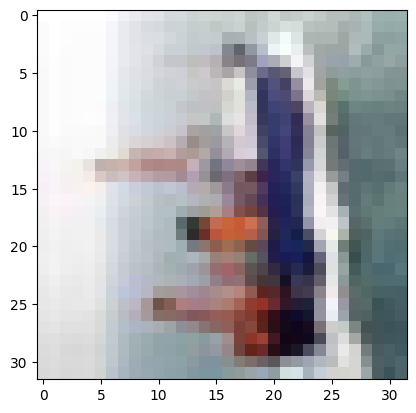

In [138]:
plt.imshow(images[7900].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [62]:
labels[9275]

6